# Complaint Classification: ML vs BERT

##  Problem Statement
The goal is to classify administrative priority of synthetic complaints 
based on their **short description, category, and location**.  

We will compare **traditional machine learning models** (Logistic Regression, Random Forest, XGBoost) 
with a **deep learning approach (BERT)** for sequence classification.

---

## Steps
1. Install dependencies & import libraries
2. Load & explore dataset
3. Encode target labels
4. Split train/test sets
5. Preprocess features (TF-IDF for text, OneHot for categories/locations)
6. Train classical ML models (LR, RF, XGB)
7. Build & train BERT (PyTorch)
8. Evaluate and compare performance
9. Visualize results


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification

c:\Users\SHAHID\OneDrive\Desktop\Python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

##  Load Dataset

In [7]:
df = pd.read_csv("data/raw/Dummy_DataSet.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (480, 4)


,short_description,category,location,admin_priority
0,Complaint: road condition unsafe in school,road,school,High
1,Complaint: can be checked water supply problem...,water,hospital,Low
2,"Broken bench found in park at highway, not severe",park,highway,Low
3,"Park is dirty near residential, problematic",park,residential,Medium
4,Complaint: garbage issue creating disturbance ...,garbage,hospital,Low


##  Target & Feature Split


# Features & Target


In [8]:
X = df[["short_description", "category", "location"]]
y = df["admin_priority"]


# Encode target labels

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [10]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


## Preprocessing for Classical ML


In [ ]:
text_transformer = TfidfVectorizer(stop_words="english")
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "short_description"),
        ("cat", categorical_transformer, ["category", "location"])
    ]
)

## 🧠 Train Classical ML Models


In [40]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

results = {}
trained_pipes = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    trained_pipes[name] = pipe  # save trained model pipeline
    
    print(f"\n{name} Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



Logistic Regression Accuracy: 0.889
              precision    recall  f1-score   support

        High       0.81      0.90      0.85        48
         Low       0.92      0.92      0.92        48
      Medium       0.95      0.85      0.90        48

    accuracy                           0.89       144
   macro avg       0.89      0.89      0.89       144
weighted avg       0.89      0.89      0.89       144


Random Forest Accuracy: 0.917
              precision    recall  f1-score   support

        High       0.88      0.92      0.90        48
         Low       0.94      0.92      0.93        48
      Medium       0.94      0.92      0.93        48

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144


XGBoost Accuracy: 0.896
              precision    recall  f1-score   support

        High       0.83      0.90      0.86        48
         Low       0.94      0.92   

c:\Users\SHAHID\OneDrive\Desktop\Python\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
new_complaints = pd.DataFrame([
    {"short_description": "Potholes on main road", "category": "Infrastructure", "location": "Delhi"},
    {"short_description": "Parking is dirty", "category": "Sanitation", "location": "Mumbai"},
    {"short_description": "Garbage not collected", "category": "Sanitation", "location": "Pune"},
    {"short_description": "Server down at ward office", "category": "Software", "location": "Bangalore"}
])

In [42]:
best_model = trained_pipes["Logistic Regression"]

In [ ]:
print("Label Encoder Classes:", label_encoder.classes_)
print("Model Classes:", pipe.classes_)


Label Encoder Classes: ['High' 'Low' 'Medium']
Model Classes: [0 1 2]


## Dataset Class for BERT


In [ ]:
class IssuesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


## Tokenization & DataLoader (BERT)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encode text
train_encodings = tokenizer(list(X_train["short_description"]), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(X_test["short_description"]), truncation=True, padding=True, max_length=64)

# Dataset & Dataloader
train_dataset = IssuesDataset(train_encodings, y_train)
test_dataset = IssuesDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


c:\Users\SHAHID\OneDrive\Desktop\Python\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SHAHID\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


##  BERT Model Setup


In [ ]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Loop (BERT)


In [ ]:
model.train()
for epoch in range(2):
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed. Last batch loss: {loss.item():.4f}")


Epoch 1 completed. Last batch loss: 0.5392
Epoch 2 completed. Last batch loss: 0.2895


## Evaluation – BERT


In [ ]:
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

bert_acc = accuracy_score(true_labels, preds)
print("BERT Accuracy:", bert_acc)
print(classification_report(true_labels, preds, target_names=label_encoder.classes_))


BERT Accuracy: 0.9097222222222222
              precision    recall  f1-score   support

        High       0.88      0.94      0.91        48
         Low       0.88      0.94      0.91        48
      Medium       0.98      0.85      0.91        48

    accuracy                           0.91       144
   macro avg       0.91      0.91      0.91       144
weighted avg       0.91      0.91      0.91       144



## Final Model Comparison


C:\Users\SHAHID\AppData\Local\Temp\ipykernel_16928\667216390.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df, x="Model", y="Accuracy", palette="viridis")


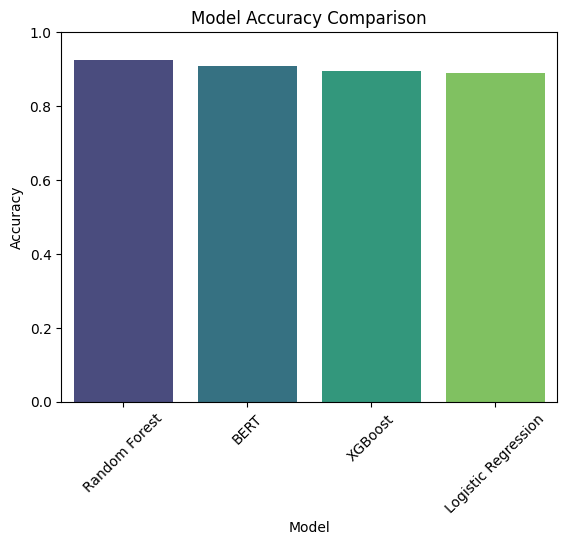

,Model,Accuracy
1,Random Forest,0.923611
3,BERT,0.909722
2,XGBoost,0.895833
0,Logistic Regression,0.888889


In [ ]:
# Add BERT result
results["BERT"] = bert_acc

# Convert to DataFrame
result_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)

# Plot
sns.barplot(data=result_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

result_df
